# Generative AI Agents

# 1. Function calling with the Gemini API

The exercise uses Gemini's API automatic function calling to build a chat interface over a local database. As it's a simple example, the function misses a number of safety and security constraints compared to real-world examples.


## Reasons to use functions over extensions
- Complete control over the logic, design, customization and implementation
- Ensure better security and privaacy as sensitive data can be processed locally
- Lowered latency and no dependency on external service availability
- Allows for a flexible system, avoid lock-ins

## Setup

In [4]:
%pip install -q -U 'google-generativeai>=0.8.3'
%pip install ipython-sql
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.
  Using cached ipython_sql-0.5.0-py3-none-any.whl.metadata (17 kB)
  Using cached prettytable-3.12.0-py3-none-any.whl.metadata (30 kB)
  Using cached SQLAlchemy-2.0.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.7 kB)
  Using cached sqlparse-0.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl.metadata (755 bytes)
  Using cached greenlet-3.1.1-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (3.8 kB)
Using cached ipython_sql-0.5.0-py3-none-any.whl (20 kB)
Using cached SQLAlchemy-2.0.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl (26 kB)
Using cached prettytable-3.12.0-py3-none-any.whl (31 kB)
Using cached sqlparse-0.5.2-py3-none-any.whl (44 kB)
Using cached greenlet-3.1.1-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (599 kB)
Note: you

In [1]:
import google.generativeai as genai
from IPython.display import Markdown
from env import *

%load_ext autoreload
%autoreload 2

In [2]:
GOOGLE_API_KEY = GOOGLE_API_KEY
genai.configure(api_key=GOOGLE_API_KEY)

## Create a local database

Creating a local SQLite database and some basic synthetic data for the example.

In [5]:
# Load the sql IPython extension
%load_ext sql
%sql sqlite:///sample.db

Create the tables and insert some synthetic data.

In [6]:
%%sql
-- Create the 'products' table
CREATE TABLE IF NOT EXISTS products (
  	product_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	product_name VARCHAR(255) NOT NULL,
  	price DECIMAL(10, 2) NOT NULL
  );

-- Create the 'staff' table
CREATE TABLE IF NOT EXISTS staff (
  	staff_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	first_name VARCHAR(255) NOT NULL,
  	last_name VARCHAR(255) NOT NULL
  );

-- Create the 'orders' table
CREATE TABLE IF NOT EXISTS orders (
  	order_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	customer_name VARCHAR(255) NOT NULL,
  	staff_id INTEGER NOT NULL,
  	product_id INTEGER NOT NULL,
  	FOREIGN KEY (staff_id) REFERENCES staff (staff_id),
  	FOREIGN KEY (product_id) REFERENCES products (product_id)
  );

-- Insert data into the 'products' table
INSERT INTO products (product_name, price) VALUES
  	('Laptop', 799.99),
  	('Keyboard', 129.99),
  	('Mouse', 29.99);

-- Insert data into the 'staff' table
INSERT INTO staff (first_name, last_name) VALUES
  	('Alice', 'Smith'),
  	('Bob', 'Johnson'),
  	('Charlie', 'Williams');

-- Insert data into the 'orders' table
INSERT INTO orders (customer_name, staff_id, product_id) VALUES
  	('David Lee', 1, 1),
  	('Emily Chen', 2, 2),
  	('Frank Brown', 1, 3);

 * sqlite:///sample.db
Done.
Done.
Done.
3 rows affected.
3 rows affected.
3 rows affected.


[]

## Define database functions

Function calling with Gemini API's Python SDK can be implemented by defining [an OpenAPI schema](https://ai.google.dev/api/caching#Schema), which is then passed to the model. Another method is to define Python functions and having the SDK define the schema automatically. In this latter case, it's important that the functions are type annotated and have accurate docstrings that describe what the functions do as the model has no insight into the function body.

By providing three key pieces of functionality - listing tables, describing a table, and executing a query - the LLM (or even another user) will have the basic tools needed to understand and interrogate the database.

A function declaration can include the following parameters:
- name (string)
- description (string)
- parameters (object)
  - type (string)
  - properties (object)
    - type (string)
    - description (string)
  - required (array)

In [7]:
import sqlite3

db_file = "sample.db"
db_conn = sqlite3.connect(db_file)

Function to list all tables in the database

In [8]:
def list_tables() -> list[str]:
    """Retrieve the names of all tables in the database."""
    # Include print logging statements so to check when functions are being called.
    print(' - DB CALL: list_tables')

    cursor = db_conn.cursor()

    # Fetch the table names.
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    return [t[0] for t in tables]


list_tables()

 - DB CALL: list_tables


['products', 'sqlite_sequence', 'staff', 'orders']

Identifying available columns in a given table.

In [9]:
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.

    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    print(' - DB CALL: describe_table')

    cursor = db_conn.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    # [column index, column name, column type, ...]
    return [(col[1], col[2]) for col in schema]


describe_table("products")

 - DB CALL: describe_table


[('product_id', 'INTEGER'),
 ('product_name', 'VARCHAR(255)'),
 ('price', 'DECIMAL(10, 2)')]

Retrieve the table

In [10]:
def execute_query(sql: str) -> list[list[str]]:
    """Execute a SELECT statement, returning the results."""
    print(' - DB CALL: execute_query')

    cursor = db_conn.cursor()

    cursor.execute(sql)
    return cursor.fetchall()


execute_query("select * from products")

 - DB CALL: execute_query


[(1, 'Laptop', 799.99),
 (2, 'Keyboard', 129.99),
 (3, 'Mouse', 29.99),
 (4, 'Laptop', 799.99),
 (5, 'Keyboard', 129.99),
 (6, 'Mouse', 29.99)]

## Implement function calls

Function calling works by defining function schemas to a model before a chat session begins. When a conversation is initiated, the model may return a `function_call` instead of sending a text reponse. When this happens, the client must respond with a `function_response`, indicating the result of the call, and the conversation can continue on as normal.

More examples shown [here](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Function_calling.ipynb)

This function calling interaction normally happens manually, allowing the client, to validate and initiate the call. However the Python SDK also supports **automatic function calling**, where the supplied functions will be automatically invoked. This is a powerful feature and should only be exposed when it is safe to do so, such as when the functions have no [side-effects](https://en.wikipedia.org/wiki/Side_effect_(computer_science)).

Here's the state diagram representing the conversation flow with function calling. With automatic function calling, the bottom row is executed automatically by the Python SDK. 

![function calling state diagram](https://codelabs.developers.google.com/static/codelabs/gemini-function-calling/img/gemini-function-calling-overview_1440.png)

In [ ]:
# These are the Python functions defined above.
from google.generativeai.types import Tool

db_tools = [list_tables, describe_table, execute_query]

instruction = """You are a helpful chatbot that can interact with an SQL database for a computer
store. You will take the users questions and turn them into SQL queries using the tools
available. Once you have the information you need, you will answer the user's question using
the data returned. Use list_tables to see what tables are present, describe_table to understand
the schema, and execute_query to issue an SQL SELECT query."""

model = genai.GenerativeModel(
    "models/gemini-1.5-flash-latest", tools=db_tools, system_instruction=instruction
)

# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

# Start a chat with automatic function calling enabled.
chat = model.start_chat(enable_automatic_function_calling=True)

<class 'list'>


Now you can engage in a chat conversation where you can ask about the contents of the database.

In [18]:
resp = chat.send_message("What is the cheapest product?", request_options=retry_policy)
print(resp.text)

 - DB CALL: list_tables
 - DB CALL: describe_table
 - DB CALL: execute_query
The cheapest product is the Mouse.


If you re-use the same [`ChatSession`](https://github.com/google-gemini/generative-ai-python/blob/main/docs/api/google/generativeai/ChatSession.md) object, the conversation will continue statefully. If you wish to start fresh, you can call [`start_chat`](https://github.com/google-gemini/generative-ai-python/blob/main/docs/api/google/generativeai/GenerativeModel.md#start_chat) again, or call [`rewind`](https://github.com/google-gemini/generative-ai-python/blob/main/docs/api/google/generativeai/ChatSession.md#rewind) on the chat object to go back a turn.

Continue the chat here by asking a follow-up question. Note that the database information is preserved, and the context of the specific product is inferred.

In [13]:
resp = chat.send_message("and how much is it?", request_options=retry_policy)
print(resp.text)

The Mouse costs $29.99.



While trying to use the `gemini-1.5-pro-latest` model, the quota ran out. Skipping usage of the model and continuing the exercise with pay-as-you-go.

### Inspecting the conversation

`chat.history` can be used to see the calls that the model makes, and what the client returns in response. This helper function will print out each turn along with the relevant fields passed or returned.

In [19]:
import textwrap


def print_chat_turns(chat):
    """Prints out each turn in the chat history, including function calls and responses."""
    for event in chat.history:
        print(f"{event.role.capitalize()}:")

        for part in event.parts:
            if txt := part.text:
                print(f'  "{txt}"')
            elif fn := part.function_call:
                args = ", ".join(f"{key}={val}" for key, val in fn.args.items())
                print(f"  Function call: {fn.name}({args})")
            elif resp := part.function_response:
                print("  Function response:")
                print(textwrap.indent(str(resp), "    "))

        print()


print_chat_turns(chat)

User:
  "What is the cheapest product?"

Model:
  Function call: list_tables()

User:
  Function response:
    name: "list_tables"
    response {
      fields {
        key: "result"
        value {
          list_value {
            values {
              string_value: "products"
            }
            values {
              string_value: "sqlite_sequence"
            }
            values {
              string_value: "staff"
            }
            values {
              string_value: "orders"
            }
          }
        }
      }
    }


Model:
  Function call: describe_table(table_name=products)

User:
  Function response:
    name: "describe_table"
    response {
      fields {
        key: "result"
        value {
          list_value {
            values {
              list_value {
                values {
                  string_value: "product_id"
                }
                values {
                  string_value: "INTEGER"
                }
              }

## Further reading

To learn more about what the Gemini API can do with function calling, check out the [Function calling cookbook](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Function_calling.ipynb) (see `Manual function calling` to understand how function calling works manually) as well as [Function calling config](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Function_calling_config.ipynb), which gives you fine-grained control over how function calling is triggered.

##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 2. Building an agent with LangGraph and the Gemini API

The example builds a cafe ordering system 'BaristaBot', providing a looping chat interface for customers to order beverages in natural language. 

[BaristaBot function calling example](https://github.com/google-gemini/cookbook/blob/main/examples/Agents_Function_Calling_Barista_Bot.ipynb) implements a similar system with minimal implication, using only the Gemini API Pythong SDK and function calling. 

## Setup

Start by installing and importing the LangGraph SDK and LangChain support for the Gemini API.

In [20]:
%pip install -qU 'langgraph==0.2.45' 'langchain-google-genai==2.0.4'

Note: you may need to restart the kernel to use updated packages.


## Key concepts

LangGraph applications are built around a **graph** structure.  In these applications, the developer defines an application graph that models the state transitions for the system.  The application includes a **state** schema, and an instance of that schema is propagated through the graph.

Each **node** in the graph represents an action or step that can be taken. Nodes modify the state in some way through developer-defined code. These changes can be the result of invoking an LLM, by calling an API, or executing any logic that the node defines.

Each **edge** in the graph represents a transition between states, defining the flow of the program. Edge transitions can be fixed—such as in a text-only chatbot where the output always transitions from `chatbot -> user`. The transitions can also be conditional, enabling branching  (like an `if-else` statement) or looping (like `for` or `while` loops).

For a deeper understanding of LangGraph’s core concepts and philosophies : [Conceptual guides](https://langchain-ai.github.io/langgraph/concepts/) and [High-level overview](https://langchain-ai.github.io/langgraph/concepts/high_level/).

## Define core instructions

State is a fundamental concept for a LangGraph app. A state object is passed between every node and transition in the app. Here a state object `OrderState` is defined, which holds the conversation history, a structured order, and a flag indicating if the customer has finished placing their order. For simplicity, the "structure" in this order is just a list of strings, but this can be expanded to any Python data structure.

In Python, the LangGraph state object is a Python [dictionary](https://docs.python.org/3/library/stdtypes.html#dict). A schema for this dictionary can be provided by defining it as a [`TypedDict`](https://docs.python.org/3/library/typing.html#typing.TypedDict).

System instruction that the Gemini model will use is also defined at this stage. Tone and style, as well as the playbook under which the chatbot should operate can be defined here. 

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
BARISTABOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

## Define a single turn chatboot

To illustrate how LangGraph works, the following program defines a chatbot node that will execute a single turn in a chat conversation using the instructions supplied.

Each node in the graph operates on the state object. The state (a Python dictionary) is passed as a parameter into the node (a function) and the new state is returned. This can be restated as pseudo-code, where `state = node(state)`.

Note: For the `chatbot` node, the state is updated by *adding* the new conversation message. The `add_messages` annotation on `OrderState.messages` indicates that messages are *appended* when returned from a node. Typically state is updated by replacement, but this annotation causes `messages` to behave differently.

In [5]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

# Using the `flash` model due to limited quota.
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")


def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph_builder = StateGraph(OrderState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

The following code renders the graph.

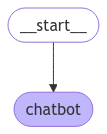

In [6]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

The graph has one node, and one transition into that node, so it will transition from `__start__` to `chatbot`, execute the `chatbot` node, and terminate.

Calling `invoke` runs the graph, and pass an initial state object. In this case it begins with the user's initial message.

In [7]:
from pprint import pprint

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

# The state object contains lots of information. Uncomment the pprint lines to see it all.
# pprint(state)

# Note that the final state now has 2 messages. Our HumanMessage, and an additional AIMessage.
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hello! I'm BaristaBot, your friendly cafe ordering system.  I can take your order for delicious drinks and treats!  What would you like to order today?  We have a wide selection of coffees, teas, pastries, and more.



This second invocation takes the state from the first call and appends another user message to elicit another response from the chatbot.

In [8]:
user_msg = "Oh great, what kinds of latte can you make?"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hello! I'm BaristaBot, your friendly cafe ordering system.  I can take your order for delicious drinks and treats!  What would you like to order today?  We have a wide selection of coffees, teas, pastries, and more.

HumanMessage: Oh great, what kinds of latte can you make?
AIMessage: We offer a variety of delicious lattes!  We have our classic Latte, a Caramel Latte, a Mocha Latte, and a Vanilla Latte.  Would you like to hear more about any of them, or would you like to start your order?



## Add a human node

Instead of repeatedly running the "graph" in a Python loop, using LangGraph to loop between nodes.

The `human` node will display the last message from the LLM to the user, and then prompt them for their next input. Here this is done using standard Python `print` and `input` functions, but for a real cafe situation, the chat can be rendered to a display or audio, and accept input from a mic or on-screen keyboard.

The `chatbot` node function has also been updated to include the welcome message to start the conversation.

In [9]:
from langchain_core.messages.ai import AIMessage


def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


# Start building a new graph.
graph_builder = StateGraph(OrderState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

Note that when adding an edge from `human` back to `chatbot`, the graph will cycle forever as there is no exit condition. One way to break the cycle is to add a check for a human input like `q` or `quit` and use that to break the loop.

In LangGraph, this is achieved with a conditional edge. This is similar to a regular graph transition, except a custom function is called to determine which edge to traverse.

Conditional edge functions take the state as input, and return a string representing the name of the node to which it will transition.

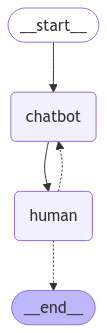

In [10]:
from typing import Literal


def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

Input `quit` to exit the program.

In [ ]:
# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
state = chat_with_human_graph.invoke({"messages": []})

# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.

pprint(state)

## Add a "live" menu

BaristaBot currently has no awareness of the available items at the cafe, so it will hallucinate a menu. One option would be to hard-code a menu into the system prompt. This would work well, but to simulate a system where the menu is more dynamic and could respond to fluctuating stock levels, the menu needs to be put into a custom tool.

There are two types of tools that this system will use. Stateless tools that can be run automatically, and stateful tools that modify the order. The "get current menu" tool is stateless, in that it does not make any changes to the live order, so it can be called automatically.

In a LangGraph app, annotate Pythoning functions as tools can be done by applying the `@tools` annotation.

In [11]:
from langchain_core.tools import tool


@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    # Note that this is just hard-coded text, but you could connect this to a live stock
    # database, or you could use Gemini's multi-modal capabilities and take live photos of
    # your cafe's chalk menu or the products on the counter and assmble them into an input.

    return """
    MENU:
    Coffee Drinks:
    Espresso
    Americano
    Cold Brew

    Coffee Drinks with Milk:
    Latte
    Cappuccino
    Cortado
    Macchiato
    Mocha
    Flat White

    Tea Drinks:
    English Breakfast Tea
    Green Tea
    Earl Grey

    Tea Drinks with Milk:
    Chai Latte
    Matcha Latte
    London Fog

    Other Drinks:
    Steamer
    Hot Chocolate

    Modifiers:
    Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
    Espresso shots: Single, Double, Triple, Quadruple; default: Double
    Caffeine: Decaf, Regular; default: Regular
    Hot-Iced: Hot, Iced; Default: Hot
    Sweeteners (option to add one or more): vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener
    Special requests: any reasonable modification that does not involve items not on the menu, for example: 'extra hot', 'one pump', 'half caff', 'extra foam', etc.

    "dirty" means add a shot of espresso to a drink that doesn't usually have it, like "Dirty Chai Latte".
    "Regular milk" is the same as 'whole milk'.
    "Sweetened" means add some regular sugar, not a sweetener.

    Soy milk has run out of stock today, so soy is not available.
  """

Now add the new tool to the graph. The `get_menu` tool is wrapped in a [`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) that handles calling the tool and passing the response as a message through the graph. The tools are also bound to the `llm` object so that the underlying model knows they exist. As there is a different `llm` object to invoke, `chatbot` node needs to be updated so that the model is aware of the tools 

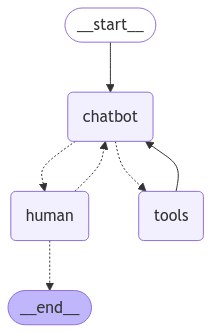

In [12]:
from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [get_menu]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: OrderState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"


def chatbot_with_tools(state: OrderState) -> OrderState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


graph_builder = StateGraph(OrderState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

In [ ]:
# Remember that you have not implemented ordering yet, so this will loop forever,
# unless you input `q`, `quit` or one of the other exit terms defined in the
# `human_node`.
# Uncomment this line to execute the graph:
state = graph_with_menu.invoke({"messages": []})

# Things to try:
# - I'd love an espresso drink, what have you got?
# - What teas do you have?
# - Can you do a long black? (this is on the menu as an "Americano" - see if it can figure it out)
# - 'q' to exit.


pprint(state)

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?


## Handle orders

To build up an order during the chat conversation, the state needs to be updated to track the order, and provide simple tools that update this state. These need to be explicit as the model should not directly have access to the apps internal state, or it risks being manipulated arbitrarily.

The ordering tools will be added as stubs in a separate node so that you can edit the state directly. Using the `@tool` annotation is still a handy way to define their schema, so the ordering tools below are implemented as empty Python functions.

In [13]:
from collections.abc import Iterable
from random import randint

from langgraph.prebuilt import InjectedState
from langchain_core.messages.tool import ToolMessage

# These functions have no body; LangGraph does not allow @tools to update
# the conversation state, so you will implement a separate node to handle
# state updates. Using @tools is still very convenient for defining the tool
# schema, so empty functions have been defined that will be bound to the LLM
# but their implementation is deferred to the order_node.


@tool
def add_to_order(drink: str, modifiers: Iterable[str]) -> str:
    """Adds the specified drink to the customer's order, including any modifiers.

    Returns:
      The updated order in progress.
    """


@tool
def confirm_order() -> str:
    """Asks the customer if the order is correct.

    Returns:
      The user's free-text response.
    """


@tool
def get_order() -> str:
    """Returns the users order so far. One item per line."""


@tool
def clear_order():
    """Removes all items from the user's order."""


@tool
def place_order() -> int:
    """Sends the order to the barista for fulfillment.

    Returns:
      The estimated number of minutes until the order is ready.
    """


def order_node(state: OrderState) -> OrderState:
    """The ordering node. This is where the order state is manipulated."""
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", [])
    outbound_msgs = []
    order_placed = False

    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_to_order":

            # Each order item is just a string. This is where it assembled as "drink (modifiers, ...)".
            modifiers = tool_call["args"]["modifiers"]
            modifier_str = ", ".join(modifiers) if modifiers else "no modifiers"

            order.append(f'{tool_call["args"]["drink"]} ({modifier_str})')
            response = "\n".join(order)

        elif tool_call["name"] == "confirm_order":

            # We could entrust the LLM to do order confirmation, but it is a good practice to
            # show the user the exact data that comprises their order so that what they confirm
            # precisely matches the order that goes to the kitchen - avoiding hallucination
            # or reality skew.

            # In a real scenario, this is where you would connect your POS screen to show the
            # order to the user.

            print("Your order:")
            if not order:
                print("  (no items)")

            for drink in order:
                print(f"  {drink}")

            response = input("Is this correct? ")

        elif tool_call["name"] == "get_order":

            response = "\n".join(order) if order else "(no order)"

        elif tool_call["name"] == "clear_order":

            order.clear()
            response = None

        elif tool_call["name"] == "place_order":

            order_text = "\n".join(order)
            print("Sending order to kitchen!")
            print(order_text)

            # TODO(you!): Implement cafe.
            order_placed = True
            response = randint(1, 5)  # ETA in minutes

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "order": order, "finished": order_placed}


def maybe_route_to_tools(state: OrderState) -> str:
    """Route between chat and tool nodes if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        # When an order is placed, exit the app. The system instruction indicates
        # that the chatbot should say thanks and goodbye at this point, so we can exit
        # cleanly.
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "ordering"

    else:
        return "human"

Now define the graph. The LLM needs to know about the tools too, so that it can invoke them. 2 sets of tools corresponding to the nodes under which they operate: automated and ordering.

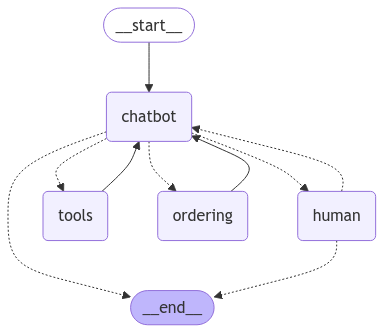

In [14]:
# Auto-tools will be invoked automatically by the ToolNode
auto_tools = [get_menu]
tool_node = ToolNode(auto_tools)

# Order-tools will be handled by the order node.
order_tools = [add_to_order, confirm_order, get_order, clear_order, place_order]

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = llm.bind_tools(auto_tools + order_tools)


graph_builder = StateGraph(OrderState)

# Nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ordering", order_node)

# Chatbot -> {ordering, tools, human, END}
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human -> {chatbot, END}
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools (both kinds) always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("ordering", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_order_tools = graph_builder.compile()

Image(graph_with_order_tools.get_graph().draw_mermaid_png())

In [ ]:
# The default recursion limit for traversing nodes is 25 - setting it higher
# means you can try a more complex order with multiple steps and round-trips.
config = {"recursion_limit": 100}

# Uncomment this line to execute the graph:
# state = graph_with_order_tools.invoke({"messages": []}, config)

# Things to try:
# - Order a drink!
# - Make a change to your order.
# - "Which teas are from England?"
# - Note that the graph should naturally exit after placing an order.

# pprint(state)

The order state has been captured both in the `place_order` function and in the final conversational state returned from executing the graph. 

In [ ]:
# Uncomment this once you have run the graph from the previous cell.
# pprint(state["order"])

## Further suggested exercises

* Adding more structure the order (`OrderState.order`) - e.g. separate fields for item, modifiers and even quantity.
* Currently the model can only clear and re-add items, so add a function to `remove_item`s from the order.
* Try building a UI that displays the in-progress order and hosts the chat. Frameworks like [Gradio](https://www.gradio.app/) or [Mesop](https://google.github.io/mesop/) are great for this.